In [3]:
import os
import tensorflow as tf
import numpy as np
import pickle
import time
#from tensorflow.python.layers import core as layers_core
#from tensorflow.contrib.seq2seq import ScheduledEmbeddingTrainingHelper
#from tensorflow.contrib.seq2seq import AttentionWrapper, AttentionWrapperState
#from tensorflow.python.ops import random_ops
#from tensorflow.python.ops import array_ops
#from tensorflow.python.ops import math_ops
#from tensorflow.python.ops import control_flow_ops
#from tensorflow.python.ops import check_ops
#from tensorflow.python.framework import ops
#from tensorflow.python.framework import dtypes
from functools import partial
from preprocess_library import SentenceBatchGenerator, Word2Numb, bin_batch_create
import bisect
from tqdm import tqdm
import argparse
from threading import Thread
import math
import matplotlib.pyplot as plt
#import winsound

In [4]:
#Sets which GPU to use
gpu_num = 1
os.environ["CUDA_VISIBLE_DEVICES"]=str(gpu_num)

In [5]:
class Config(object):
    """The model configuration
    """

    def __init__(self,
                 chan_enc_layers, #Could be a scalar(num of hidden layers) or a list(dims of hidden layers)
                 chan_dec_layers, #Could be a scalar(num of hidden layers) or a list(dims of hidden layers)
                 
                 numb_tx_bits, # Could be a list for variable length
                 chan_dec_out_len, #==chan_enc_in_len
                 
                 channel={'type':'erasure','chan_param':0.9},
                 num_epochs=100,
                 learn_rate=0.001,
                
                 enc_hidden_act = tf.nn.relu,
                 dec_hidden_act = tf.nn.relu,
                 iter_save_rate = 10000,
                 model_save_path = "checkpoints/",
                 save_max = 5,
                 
                 batch_size = 1,
                 batch_size_test = 128,
                 length_from=4,
                 length_to=30,
                 bin_len = 4,
                 bits_per_bin = [200,250,300,350,400,450,500],
                 
                 dataset = 'euro',
                 w2n_path="../data/w2n_n2w_TopEuro.pickle",
#                 traindata_path="../../data/training_euro_wordlist20.pickle",
                 traindata_path="../data/corpora/europarl-v7.en/europarl-v7.en",
#                 testdata_path="../../data/testing_euro_wordlist20.pickle",
                 testdata_path="../data/corpora/europarl-v7.en/europarl-v7.en",
                 embed_path="../data/200_embed_large_TopEuro.pickle",
                 max_test_counter = int(1e6),
                 max_validate_counter = 10000,
                 max_batch_in_epoch = 1000,
                 iter_print_rate = None):
        """
        Args:
            model_save_path - path where the model is saved
            channel - dict with keys type [erasure,awgn] and chan_param
            bits_per_bin - ensure this is even and of the same size as the number of batches 
        """
        
        if isinstance(chan_enc_layers, list):
            self.enc_layers_dims = chan_enc_layers
            self.num_enc_layers = len(chan_enc_layers)
        else:
            self.num_enc_layers = chan_enc_layers
            self.enc_layers_dims = None

        if isinstance(chan_dec_layers, list):
            self.dec_layers_dims = chan_dec_layers
            self.num_dec_layers = len(chan_dec_layers)
        else:
            self.num_dec_layers = chan_dec_layers
            self.dec_layers_dims = None
        
        self.enc_hidden_act = enc_hidden_act
        self.dec_hidden_act = dec_hidden_act
        self.epochs = num_epochs
        self.learn_rate = learn_rate
        self.chan_dec_out_len = chan_dec_out_len
        self.chan_enc_in_len = chan_dec_out_len
        
        #batch properties
        self.batch_size = batch_size
        
        self.channel = channel
        self.numb_tx_bits = numb_tx_bits
        self.iter_save_rate = iter_save_rate
        self.model_save_path = model_save_path
        
        self.traindata_path = traindata_path
        self.testdata_path = testdata_path
        self.max_test_counter = max_test_counter
        self.max_batch_in_epoch = max_batch_in_epoch
        self.iter_print_rate = max_batch_in_epoch if iter_print_rate == None else iter_print_rate
        self.save_max = save_max

In [6]:
class ChannelEncoder(object):
    """
    Channel encoder object. 
    Takes in a bit vector of compressed states from a stacked BLSTM. 
    Outputs a bit vector of the specified length to be passed through the channel, with redundancy added through an
    MLP network
    """
    def __init__(self, chan_enc_input, isTrain, config):
        
        self.config = config
        self.input = chan_enc_input
        self.input_len = config.chan_enc_in_len
        self.batch_size = config.batch_size
        self.isTrain = isTrain
        
        self.reduced_states = self.build_enc_net()
        print("reduced states:", self.reduced_states)
        self.output = self.binarize(self.reduced_states)
        
        print("Output from channel encoder: ", self.output)
    
    def get_net_dims(self, n_in, n_out):
        
        if (self.config.enc_layers_dims != None):
            return self.config.enc_layers_dims
        
        num_hidden_layers = self.config.num_enc_layers #num_hidden >= 2
        hidden_dims = []
        
        """
        Uses ideas from D.Stathakis' paper to determine the number of neurons for first 2 hidden layers
        """
        n_h1 = int(math.sqrt((n_out + 2) * n_in) + 2 * math.sqrt(n_in / (n_out + 2)))
        n_h2 = int(n_out * math.sqrt(n_in / (n_out + 2)))

        hidden_dims.append(n_h1)
        if (self.config.num_enc_layers > 1):
            hidden_dims.append(n_h2)
        
        #For remaining layers
        
        for _ in range(num_hidden_layers - 2):
            
            hidden_dims.append(int(hidden_dims[-1] * 0.8))
            
        
        return hidden_dims
    
    def build_enc_net(self):
        """
        Builds the channel encoder
        """
        print(self.input_len, self.config.numb_tx_bits)
        hidden_dims = self.get_net_dims(self.input_len, self.config.numb_tx_bits) #length >= 1
   
        print("Hidden encoder dimensions: ", hidden_dims)

        hidden_layers = [] #list of tensors for storing activations from each hidden layer
        
        print("Input dims:", self.input)

        print("Test", self.input.dtype.base_dtype)
    
        hidden_act1 = tf.layers.dense(self.input, hidden_dims[0], 
                                      activation = self.config.enc_hidden_act,
                                      kernel_initializer = tf.contrib.layers.xavier_initializer(),
                                      name = "chan_enc_h1") 
        
        print("hidden1", hidden_act1)
        hidden_layers.append(hidden_act1)
        
        for i in range(1, len(hidden_dims)):
        
#             hidden_act = tf.contrib.layers.fully_connected(hidden_layers[-1], 
#                                                            hidden_dims[i], 
#                                                            activation_fn = self.config.enc_hidden_act) 
            hidden_act = tf.layers.dense(hidden_layers[-1], hidden_dims[i], activation = self.config.enc_hidden_act,
                                         kernel_initializer = tf.contrib.layers.xavier_initializer(),
                                         name = "chan_enc_h" + str(i + 1)) 
            hidden_layers.append(hidden_act)
        
        if (len(hidden_dims) > 1):
            #Skip connection between h1 and output feed
            output_feed = tf.concat([hidden_act1, hidden_layers[-1]], axis = 1)
            print("Encoder test:", output_feed)
        else:
            output_feed = hidden_layers[-1]
            
        b_norm_output_feed = tf.contrib.layers.batch_norm(output_feed)
        
        out_states = tf.layers.dense(b_norm_output_feed, self.config.numb_tx_bits, activation = tf.tanh,
                                     kernel_initializer = tf.contrib.layers.xavier_initializer(),
                                     name = "chan_enc_out") 
        return out_states
        
    def training_binarizer(self, input_layer):
        """Binarizer function used at training
        """
        prob = tf.truediv(tf.add(1.0, input_layer), 2.0)
        bernoulli = tf.contrib.distributions.Bernoulli(probs=prob, dtype=tf.float32)
        return 2 * bernoulli.sample() - 1

    def test_binarizer(self, input_layer):
        """Binarizer function used during testing
        """
        ones = tf.ones_like(input_layer,dtype=tf.float32)
        neg_ones = tf.scalar_mul(-1.0, ones)
        return tf.where(tf.less(input_layer,0.0), neg_ones, ones)
    
    def binarize(self, reduced_states):
        binarized = tf.cond(self.isTrain,
                            partial(self.training_binarizer, reduced_states),
                            partial(self.test_binarizer, reduced_states))
        
        pass_through = tf.identity(reduced_states) # this is used for pass through gradient back prop
        return pass_through + tf.stop_gradient(binarized - pass_through)
    
    
    

In [7]:
class Channel(object):
    """
    Takes in embedding vectors converted to bits, and models the impact of a channel on them
    """
    def __init__(self, channel_in, config):
        self.config = config
        self.chan_type = config.channel["type"] #dict of items type and chan_param
        self.chan_param = config.channel["chan_param"]
        self.input = channel_in
        self.output = self.build_channel()
        print("Channel Output: ", self.output)
        
    def gaussian_noise_layer(self, input_layer, std, name=None):
        noise = tf.random_normal(shape=tf.shape(input_layer), mean=0.0,
                                 stddev=std, dtype=tf.float32, name=name)
        return input_layer + noise

    def test_binarizer(self, input_layer):
        """Binarizer function used during testing
        """
        ones = tf.ones_like(input_layer,dtype=tf.float32)
        neg_ones = tf.scalar_mul(-1.0, ones)
        return tf.where(tf.less(input_layer,0.0), neg_ones, ones)
    
    def build_channel(self):
        """Build the final binarization layer and the channel
        """
        # if no channel, just output the encoder states
        if self.chan_type == "none":
            chan_output = self.input
            
        elif self.chan_type == "erasure":
            chan_output = tf.nn.dropout(self.input,
                                         keep_prob=self.chan_param,
                                         name="erasure_chan_dropout_ch")
                            
        elif self.chan_type == "awgn":
            chan_output = self.gaussian_noise_layer(self.channel_in,
                                             std=self.chan_param,
                                             name="awgn_chan_noise")
            
        elif self.type == 'bsc':
            
            chan_output = tf.where(tf.greater(tf.random_uniform(shape=tf.shape(self.channel_in)),
                                              self.chan_param),
                                   self.channel_in,
                                   -self.channel_in)
            
        else:
            raise NameError('Channel type is not known.')

        return chan_output

In [8]:
class ChannelDecoder(object):
    """
    A decoder that uses a fully connected net to convert channel output to original channel encoding
    Takes in a bit vector from the channel
    Outputs a vector of same length as input to chann encoder on the other side of channel, with (ideally) identical elements
    
    """
    def __init__(self, chan_out, isTrain, config):
        
        self.config = config
        self.dec_input = chan_out
        self.dec_inp_len = config.numb_tx_bits
        self.output_len = config.chan_dec_out_len
        self.batch_size = config.batch_size
        self.num_hidden_layers = config.num_dec_layers
        self.isTrain = isTrain
        self.dec_network_out = self.build_dec_net()
      
        self.bin_pred = tf.where(tf.less(self.dec_network_out,0.0), 
                                 -1 * tf.ones_like(self.dec_network_out,dtype=tf.float32), 
                                 tf.ones_like(self.dec_network_out,dtype=tf.float32))
    
    def get_net_dims(self, n_in, n_out):
        
        layer_drop_const = 0.95
        
        if (self.config.dec_layers_dims != None):
            return self.config.dec_layers_dims
        
        num_hidden_layers = self.config.num_dec_layers #num_hidden >= 1
        hidden_dims = []
        
        """
        Uses ideas from D.Stathakis' paper to determine the number of neurons for first 2 hidden layers
        """
        n_h1 = int(math.sqrt((n_out + 2) * n_in) + 2 * math.sqrt(n_in / (n_out + 2)))
        n_h2 = int(n_out * math.sqrt(n_in / (n_out + 2)))

        hidden_dims.append(n_h1)
        if (self.config.num_dec_layers > 1):
            hidden_dims.append(n_h2)
        
        #For remaining layers
        
        for _ in range(num_hidden_layers - 2):
            
            hidden_dims.append(int(hidden_dims[-1] * layer_drop_const))
            
        
        return hidden_dims
    
    
    def build_dec_net(self):
        """
        Builds the channel encoder
        """
 
        hidden_dims = self.get_net_dims(self.dec_inp_len, self.output_len) 
        #hidden_dims = [2048, 1024, 512, 256, 128]
        print("Hidden decoder dimensions: ", hidden_dims)
        hidden_layers = [] #list of tensors for storing activations from each hidden layer
        
        hidden_act1 = tf.layers.dense(self.dec_input, hidden_dims[0], 
                                      activation = self.config.dec_hidden_act, 
                                      kernel_initializer = tf.contrib.layers.xavier_initializer(), 
                                      name = "chan_dec_h1") 

        hidden_layers.append(hidden_act1)
        
        for i in range(1, len(hidden_dims)):
        
            hidden_act = tf.layers.dense(hidden_layers[-1],
                                         hidden_dims[i], 
                                         activation = self.config.dec_hidden_act,
                                         kernel_initializer = tf.contrib.layers.xavier_initializer(),
                                         name = "chan_dec_h" + str(i + 1)) 

            hidden_layers.append(hidden_act)
        
        if (len(hidden_dims) > 1):
            #Skip connection between h1 and output feed
            output_feed = tf.concat([hidden_act1, hidden_layers[-1]], axis = 1)
            print("Decoder test:", output_feed)
        else:
            output_feed = hidden_layers[-1]    

        out_states = tf.layers.dense(output_feed, 
                                     self.output_len, 
                                     activation = None, 
                                     kernel_initializer = tf.contrib.layers.xavier_initializer(),
                                     name = "chan_dec_out")
    
        print("Dec out", out_states)                                               
        return out_states
        

    def training_binarizer(self, input_layer):
        """Binarizer function used at training
        """
        prob = tf.truediv(tf.add(1.0, input_layer), 2.0)
        bernoulli = tf.contrib.distributions.Bernoulli(probs=prob, dtype=tf.float32)
        return 2 * bernoulli.sample() - 1

    def test_binarizer(self, input_layer):
        """Binarizer function used during testing
        """
        ones = tf.ones_like(input_layer,dtype=tf.float32)
        neg_ones = tf.scalar_mul(-1.0, ones)
        return tf.where(tf.less(input_layer,0.0), neg_ones, ones)

    def binarize(self,input_layer):
        """This part of the code binarizes the reduced states. The last line ensure the
        backpropagation gradients pass through the binarizer unchanged
        """
        binarized = tf.cond(self.isTrain,
                            partial(self.training_binarizer, input_layer),
                            partial(self.test_binarizer, input_layer))

        pass_through = tf.identity(input_layer) # this is used for pass through gradient back prop
        return pass_through + tf.stop_gradient(binarized - pass_through )
        
        

In [26]:
#Previous learn_rate policy
class ChannelSystem(object):
    """
    Generates a channel coding model with encoder + channel + decoder.
    """

    def __init__(self, config, train_size, test_size):
        self.config = config
        self.training_counter = 0
        self.test_counter = 0
        #self.train_data = train_data
        #self.test_data = test_data
        self.train_size = train_size
        self.test_size = test_size 
        # ==== reset graph ====
        tf.reset_default_graph()
          
        self.chan_enc_in_len = config.chan_enc_in_len
        self.chan_dec_out_len = config.chan_dec_out_len
        
        #===Legacy placeholders====
        #self.chan_enc_inputs = tf.placeholder_with_default(queue_vars['enc_inputs'],shape=(config.batch_size, None), name='encoder_inputs')
        #self.chan_enc_inputs_len = tf.placeholder_with_default(queue_vars['enc_inputs_len'],shape=(None,), name='encoder_inputs_length')
        #self.dec_inputs = tf.placeholder_with_default(queue_vars['dec_inputs'],shape=(config.batch_size, None), name='decoder_targets')
        #self.dec_targets = tf.placeholder_with_default(queue_vars['dec_targets'],shape=(config.batch_size, None), name='decoder_targets')
 
        
        # ======= Placeholders =======        
        self.chan_enc_inputs = tf.placeholder(tf.float32, shape = [None, self.chan_enc_in_len], name = 'enc_inputs')
        self.dec_targets = tf.placeholder(tf.float32, shape = [None, self.chan_dec_out_len], name = 'dec_targets')
        self.isTrain = tf.placeholder(tf.bool,shape=(), name='isTrain')

        self.learn_rate = tf.placeholder(tf.float32,shape=(), name='learn_rate')
        
        self.X = tf.placeholder(tf.float32, shape = [None, self.chan_enc_in_len], name = 'dataset_iter_X')
        self.Y = tf.placeholder(tf.float32, shape = [None, self.chan_dec_out_len], name = 'dataset_iter_Y')
        print("X:", self.X)  
        self.dataset = tf.data.Dataset.from_tensor_slices((self.X, self.Y)).shuffle(buffer_size=100).batch(config.batch_size).repeat()
        
        self.iterator = self.dataset.make_initializable_iterator()
        
        self.chan_enc_inputs, self.dec_targets = self.iterator.get_next()
        # ==== Building neural network graph ====
        
        
        self.chan_encoder = ChannelEncoder(self.chan_enc_inputs, 
                                       self.isTrain,
                                       self.config)

        self.channel = Channel(self.chan_encoder.output,
                               self.config)
        
        self.decoder = ChannelDecoder(self.channel.output,
                                     self.isTrain,
                                     self.config)

        
        # ==== define loss and training op and accuracy ====
        
        self.accuracy = self.define_accuracy()
        self.loss, self.train_op = self.define_loss()

        # ==== set up training/updating procedure ====
        self.saver = tf.train.Saver(max_to_keep = self.config.save_max)


#     def load_trained_model(self, sess, model_save_path):
#         """
#         Loads a trained model from what was saved. Insert the trained model path
#         """
#         meta_file_path = model_save_path + ".meta"
        
#         new_saver = tf.train.import_meta_graph(meta_file_path) #Loads graph
#         new_saver.restore(sess, tf.train.latest_checkpoint('checkpoints/'))
        
#         #Test
#         variables_names = [v.name for v in tf.trainable_variables()]
#         values = sess.run(variables_names)
#         print("Printing restored variables:")
#         for k, v in zip(variables_names, values):
#             print ("Variable: ", k)
#             print ("Shape: ", v.shape)
#             print (v)

    def define_accuracy(self):
        eq_indicator = tf.cast(tf.equal(self.decoder.bin_pred, self.dec_targets), dtype=tf.float32)
        return tf.reduce_mean(eq_indicator)

    def define_loss(self):
        
        adapted_targets = tf.cast(self.dec_targets > 0, tf.float32)
        loss = tf.losses.hinge_loss(adapted_targets, self.decoder.dec_network_out)

        # train it
        train_op = tf.train.AdamOptimizer(learning_rate=self.learn_rate).minimize(loss)
        return loss, train_op
    
    """
    Script to generate train and test data
    """
    def gen_bin_data(self, num_samples, sample_len, seed_num = None):
        
        if (seed_num != None):
            np.random.seed(seed_num)
        randMat = np.random.rand(num_samples, sample_len)
        binMat = np.where(randMat > 0.5, 1.0, -1.0)
        return binMat

          
    def train_and_test(self, sess, grammar=None):
        """
        Trains the model
        """
        try:
            n_epochs = self.config.epochs
            batch_sz = self.config.batch_size
            max_batch = self.config.max_batch_in_epoch

            sess.run(tf.global_variables_initializer())

            #Train on train data
            print("Training...")
            tic = time.time()

            accuracies = []
            learn_rates = []
        
            #train_data_gen = self.gen_bin_data(self.train_size, self.chan_enc_in_len)

            curr_lr = self.config.learn_rate
            
            for epoch in range(n_epochs):
                train_data = self.gen_bin_data(self.train_size, self.chan_enc_in_len)
                sess.run(self.iterator.initializer, feed_dict = {self.X: train_data, self.Y: train_data})
                len_acc = len(accuracies)
                if (len_acc > 2 and epoch % 2 == 0):
                    if ((len_acc <= 10 and np.mean(accuracies[-3:-1]) > accuracies[-1]) or 
                        (len_acc in range(11, 51) and np.mean(accuracies[-6:-2]) > np.mean(accuracies[-2:])) or 
                        (len_acc in range(51, 101) and np.mean(accuracies[-10:-4]) > np.mean(accuracies[-4:])) or 
                        (len_acc in range(101, 201) and np.mean(accuracies[-30:-10]) > np.mean(accuracies[-10:])) or
                        (len_acc > 200 and np.mean(accuracies[-50:-10]) > np.mean(accuracies[-10:]))):
                            
                            if (curr_lr > 1e-12):
                                curr_lr = curr_lr / np.sqrt(2)
                learn_rates.append(curr_lr)
                for i in range(max_batch):               

                    train_fd = {self.isTrain: True, self.learn_rate: curr_lr}       
                    _, loss = sess.run([self.train_op, self.loss], feed_dict = train_fd)

                    self.training_counter += 1

                    if (self.training_counter % self.config.iter_print_rate == 0):

                        toc = time.time()

                        acc = sess.run(self.accuracy, train_fd)

                        print("Epoch: ", epoch + 1, 
                              "Accuracy: ", acc,
                              "Training iteration: ", self.training_counter,
                              "Training time: ", int(toc-tic), "s",
                              "Training loss: ", loss,
                              "Learning rate", curr_lr)
                        accuracies.append(acc)

                    if self.training_counter % self.config.iter_save_rate == 0:
                        if (len(accuracies) > 1 and accuracies[-1] > np.amax(accuracies[:-1])):
                            self.saver.save(sess, self.config.model_save_path, global_step=self.training_counter)
                            print("Model saved in file: %s" % self.config.model_save_path)

        except KeyboardInterrupt:
            print("Training interrupted")
            
        #Save model, plot accuracies    
        self.saver.save(sess, self.config.model_save_path, global_step=self.training_counter)
        print("Model saved in file: %s" % self.config.model_save_path) 
        
        plt.plot(accuracies)
        plt.title("Accuracies vs epochs")
        plt.xlabel('epochs')
        plt.ylabel('Acc')
        plt.grid(True)               
            
        #Test on test data    
        test_data = self.gen_bin_data(self.test_size, self.chan_enc_in_len)

        sess.run(self.iterator.initializer, feed_dict = {self.X: test_data, self.Y: test_data})
        print("Testing...")
        
        test_fd = {self.isTrain: False, self.learn_rate: self.config.learn_rate} 
        test_loss = sess.run(self.loss, feed_dict = test_fd)
        
        test_acc = sess.run(self.accuracy, test_fd)
        
        print("Test loss: ", test_loss, "\nTest accuracy: ", test_acc)
            
        return (accuracies, test_acc, learn_rates)
    

In [11]:
def train_model(config, train_size, test_size):
   
    channel_sys = ChannelSystem(chan_enc_config, train_size,test_size)
    with tf.Session() as sess:
        train_acc, test_acc, learn_rates = channel_sys.train_and_test(sess)
    
    return (train_acc, test_acc, learn_rates)

In [19]:
chan_enc_layers = [4096, 2048, 1024, 512]
chan_dec_layers = [4096, 2048, 1600, 1024, 512]

chan_keep_prob = 0.925
channel = {'type':'erasure','chan_param':chan_keep_prob}

chan_enc_in_len = 400
code_rate = 0.90
num_tx_bits = np.ceil(chan_enc_in_len / code_rate)

num_epochs = 150
num_train = int(1e6)
num_test = int(1e6)
batch_size = 1000
max_batch_in_epoch = int(1 * 1e3)
learn_rate = 0.0001 
model_save_path = "checkpoints/test_model"
iter_save_rate = max_batch_in_epoch

chan_enc_config = Config(chan_enc_layers,
                        chan_dec_layers,
                        num_tx_bits,
                        chan_enc_in_len, #==chan_dec_out_len
                        channel = channel,
                        num_epochs = num_epochs,
                        learn_rate = learn_rate,
                        
                        batch_size = batch_size,
                        max_batch_in_epoch = max_batch_in_epoch, 
                        iter_save_rate = iter_save_rate,
                        model_save_path = model_save_path,
                        save_max = 10)

train_accs, test_acc, learn_rates = train_model(chan_enc_config, num_train, num_test)


X: Tensor("dataset_iter_X:0", shape=(?, 400), dtype=float32)
400 445.0
Hidden encoder dimensions:  [4096, 2048, 1024, 512]
Input dims: Tensor("IteratorGetNext:0", shape=(?, 400), dtype=float32)
Test <dtype: 'float32'>
hidden1 Tensor("chan_enc_h1/Relu:0", shape=(?, 4096), dtype=float32)
Encoder test: Tensor("concat:0", shape=(?, 4608), dtype=float32)
reduced states: Tensor("chan_enc_out/Tanh:0", shape=(?, 445), dtype=float32)
Output from channel encoder:  Tensor("add:0", shape=(?, 445), dtype=float32)
Channel Output:  Tensor("erasure_chan_dropout_ch/mul:0", shape=(?, 445), dtype=float32)
Hidden decoder dimensions:  [4096, 2048, 1600, 1024, 512]
Decoder test: Tensor("concat_1:0", shape=(?, 4608), dtype=float32)
Dec out Tensor("chan_dec_out/BiasAdd:0", shape=(?, 400), dtype=float32)
Training...
Epoch:  1 Accuracy:  0.846725 Training iteration:  1000 Training time:  43 s Training loss:  0.37268272 Learning rate 8.003998000000001e-05
Epoch:  2 Accuracy:  0.849745 Training iteration:  2000 T

Model saved in file: checkpoints/test_model
Epoch:  49 Accuracy:  0.8673425 Training iteration:  49000 Training time:  2115 s Training loss:  0.31870994 Learning rate 8.000001999999994e-05
Model saved in file: checkpoints/test_model
Epoch:  50 Accuracy:  0.8711225 Training iteration:  50000 Training time:  2159 s Training loss:  0.3075071 Learning rate 9.998002000000006e-05
Model saved in file: checkpoints/test_model
Epoch:  51 Accuracy:  0.87648 Training iteration:  51000 Training time:  2202 s Training loss:  0.29869553 Learning rate 8.003998000000003e-05
Model saved in file: checkpoints/test_model
Epoch:  52 Accuracy:  0.87977 Training iteration:  52000 Training time:  2246 s Training loss:  0.28989547 Learning rate 6.005997999999992e-05
Model saved in file: checkpoints/test_model
Epoch:  53 Accuracy:  0.8814075 Training iteration:  53000 Training time:  2290 s Training loss:  0.28205243 Learning rate 4.0079979999999994e-05
Model saved in file: checkpoints/test_model
Epoch:  54 Accu

ResourceExhaustedError: checkpoints/test_model-59000.data-00000-of-00001.tempstate4085270137444843128; No space left on device
	 [[Node: save/SaveV2 = SaveV2[dtypes=[DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, ..., DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT], _device="/job:localhost/replica:0/task:0/device:CPU:0"](_arg_save/Const_0_0, save/SaveV2/tensor_names, save/SaveV2/shape_and_slices, BatchNorm/beta/_31, BatchNorm/beta/Adam/_33, BatchNorm/beta/Adam_1/_35, BatchNorm/moving_mean/_37, BatchNorm/moving_variance/_39, beta1_power/_41, beta2_power/_43, chan_dec_h1/bias/_45, chan_dec_h1/bias/Adam/_47, chan_dec_h1/bias/Adam_1/_49, chan_dec_h1/kernel/_51, chan_dec_h1/kernel/Adam/_53, chan_dec_h1/kernel/Adam_1/_55, chan_dec_h2/bias/_57, chan_dec_h2/bias/Adam/_59, chan_dec_h2/bias/Adam_1/_61, chan_dec_h2/kernel/_63, chan_dec_h2/kernel/Adam/_65, chan_dec_h2/kernel/Adam_1/_67, chan_dec_h3/bias/_69, chan_dec_h3/bias/Adam/_71, chan_dec_h3/bias/Adam_1/_73, chan_dec_h3/kernel/_75, chan_dec_h3/kernel/Adam/_77, chan_dec_h3/kernel/Adam_1/_79, chan_dec_h4/bias/_81, chan_dec_h4/bias/Adam/_83, chan_dec_h4/bias/Adam_1/_85, chan_dec_h4/kernel/_87, chan_dec_h4/kernel/Adam/_89, chan_dec_h4/kernel/Adam_1/_91, chan_dec_h5/bias/_93, chan_dec_h5/bias/Adam/_95, chan_dec_h5/bias/Adam_1/_97, chan_dec_h5/kernel/_99, chan_dec_h5/kernel/Adam/_101, chan_dec_h5/kernel/Adam_1/_103, chan_dec_out/bias/_105, chan_dec_out/bias/Adam/_107, chan_dec_out/bias/Adam_1/_109, chan_dec_out/kernel/_111, chan_dec_out/kernel/Adam/_113, chan_dec_out/kernel/Adam_1/_115, chan_enc_h1/bias/_117, chan_enc_h1/bias/Adam/_119, chan_enc_h1/bias/Adam_1/_121, chan_enc_h1/kernel/_123, chan_enc_h1/kernel/Adam/_125, chan_enc_h1/kernel/Adam_1/_127, chan_enc_h2/bias/_129, chan_enc_h2/bias/Adam/_131, chan_enc_h2/bias/Adam_1/_133, chan_enc_h2/kernel/_135, chan_enc_h2/kernel/Adam/_137, chan_enc_h2/kernel/Adam_1/_139, chan_enc_h3/bias/_141, chan_enc_h3/bias/Adam/_143, chan_enc_h3/bias/Adam_1/_145, chan_enc_h3/kernel/_147, chan_enc_h3/kernel/Adam/_149, chan_enc_h3/kernel/Adam_1/_151, chan_enc_h4/bias/_153, chan_enc_h4/bias/Adam/_155, chan_enc_h4/bias/Adam_1/_157, chan_enc_h4/kernel/_159, chan_enc_h4/kernel/Adam/_161, chan_enc_h4/kernel/Adam_1/_163, chan_enc_out/bias/_165, chan_enc_out/bias/Adam/_167, chan_enc_out/bias/Adam_1/_169, chan_enc_out/kernel/_171, chan_enc_out/kernel/Adam/_173, chan_enc_out/kernel/Adam_1/_175)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


Caused by op 'save/SaveV2', defined at:
  File "/usr/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.6/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python3.6/dist-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.6/dist-packages/tornado/platform/asyncio.py", line 112, in start
    self.asyncio_loop.run_forever()
  File "/usr/lib/python3.6/asyncio/base_events.py", line 422, in run_forever
    self._run_once()
  File "/usr/lib/python3.6/asyncio/base_events.py", line 1432, in _run_once
    handle._run()
  File "/usr/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/usr/local/lib/python3.6/dist-packages/tornado/platform/asyncio.py", line 102, in _handle_events
    handler_func(fileobj, events)
  File "/usr/local/lib/python3.6/dist-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/usr/local/lib/python3.6/dist-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/local/lib/python3.6/dist-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/local/lib/python3.6/dist-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/local/lib/python3.6/dist-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/usr/local/lib/python3.6/dist-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python3.6/dist-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 2728, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 2850, in run_ast_nodes
    if self.run_code(code, result):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-19-f71af896bb25>", line 34, in <module>
    train_accs, test_acc, learn_rates = train_model(chan_enc_config, num_train, num_test)
  File "<ipython-input-11-e5bc2afdffe2>", line 3, in train_model
    channel_sys = ChannelSystem(chan_enc_config, train_size,test_size)
  File "<ipython-input-16-c0bed315d201>", line 64, in __init__
    self.saver = tf.train.Saver(max_to_keep = self.config.save_max)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/training/saver.py", line 1338, in __init__
    self.build()
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/training/saver.py", line 1347, in build
    self._build(self._filename, build_save=True, build_restore=True)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/training/saver.py", line 1384, in _build
    build_save=build_save, build_restore=build_restore)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/training/saver.py", line 832, in _build_internal
    save_tensor = self._AddSaveOps(filename_tensor, saveables)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/training/saver.py", line 350, in _AddSaveOps
    save = self.save_op(filename_tensor, saveables)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/training/saver.py", line 266, in save_op
    tensors)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gen_io_ops.py", line 1687, in save_v2
    shape_and_slices=shape_and_slices, tensors=tensors, name=name)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/ops.py", line 3392, in create_op
    op_def=op_def)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/ops.py", line 1718, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

ResourceExhaustedError (see above for traceback): checkpoints/test_model-59000.data-00000-of-00001.tempstate4085270137444843128; No space left on device
	 [[Node: save/SaveV2 = SaveV2[dtypes=[DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, ..., DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT], _device="/job:localhost/replica:0/task:0/device:CPU:0"](_arg_save/Const_0_0, save/SaveV2/tensor_names, save/SaveV2/shape_and_slices, BatchNorm/beta/_31, BatchNorm/beta/Adam/_33, BatchNorm/beta/Adam_1/_35, BatchNorm/moving_mean/_37, BatchNorm/moving_variance/_39, beta1_power/_41, beta2_power/_43, chan_dec_h1/bias/_45, chan_dec_h1/bias/Adam/_47, chan_dec_h1/bias/Adam_1/_49, chan_dec_h1/kernel/_51, chan_dec_h1/kernel/Adam/_53, chan_dec_h1/kernel/Adam_1/_55, chan_dec_h2/bias/_57, chan_dec_h2/bias/Adam/_59, chan_dec_h2/bias/Adam_1/_61, chan_dec_h2/kernel/_63, chan_dec_h2/kernel/Adam/_65, chan_dec_h2/kernel/Adam_1/_67, chan_dec_h3/bias/_69, chan_dec_h3/bias/Adam/_71, chan_dec_h3/bias/Adam_1/_73, chan_dec_h3/kernel/_75, chan_dec_h3/kernel/Adam/_77, chan_dec_h3/kernel/Adam_1/_79, chan_dec_h4/bias/_81, chan_dec_h4/bias/Adam/_83, chan_dec_h4/bias/Adam_1/_85, chan_dec_h4/kernel/_87, chan_dec_h4/kernel/Adam/_89, chan_dec_h4/kernel/Adam_1/_91, chan_dec_h5/bias/_93, chan_dec_h5/bias/Adam/_95, chan_dec_h5/bias/Adam_1/_97, chan_dec_h5/kernel/_99, chan_dec_h5/kernel/Adam/_101, chan_dec_h5/kernel/Adam_1/_103, chan_dec_out/bias/_105, chan_dec_out/bias/Adam/_107, chan_dec_out/bias/Adam_1/_109, chan_dec_out/kernel/_111, chan_dec_out/kernel/Adam/_113, chan_dec_out/kernel/Adam_1/_115, chan_enc_h1/bias/_117, chan_enc_h1/bias/Adam/_119, chan_enc_h1/bias/Adam_1/_121, chan_enc_h1/kernel/_123, chan_enc_h1/kernel/Adam/_125, chan_enc_h1/kernel/Adam_1/_127, chan_enc_h2/bias/_129, chan_enc_h2/bias/Adam/_131, chan_enc_h2/bias/Adam_1/_133, chan_enc_h2/kernel/_135, chan_enc_h2/kernel/Adam/_137, chan_enc_h2/kernel/Adam_1/_139, chan_enc_h3/bias/_141, chan_enc_h3/bias/Adam/_143, chan_enc_h3/bias/Adam_1/_145, chan_enc_h3/kernel/_147, chan_enc_h3/kernel/Adam/_149, chan_enc_h3/kernel/Adam_1/_151, chan_enc_h4/bias/_153, chan_enc_h4/bias/Adam/_155, chan_enc_h4/bias/Adam_1/_157, chan_enc_h4/kernel/_159, chan_enc_h4/kernel/Adam/_161, chan_enc_h4/kernel/Adam_1/_163, chan_enc_out/bias/_165, chan_enc_out/bias/Adam/_167, chan_enc_out/bias/Adam_1/_169, chan_enc_out/kernel/_171, chan_enc_out/kernel/Adam/_173, chan_enc_out/kernel/Adam_1/_175)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.



0.964


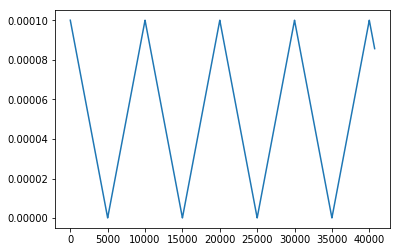

In [27]:
plt.plot(learn_rates)
print(train_accs[-4])
accs_file = open('train_accs.txt', 'w')
for item in train_accs:
    accs_file.write("%s\n" % item)

In [16]:
#Implements CLR
class ChannelSystem(object):
    """
    Generates a channel coding model with encoder + channel + decoder.
    """

    def __init__(self, config, train_size, test_size):
        self.config = config
        self.training_counter = 0
        self.test_counter = 0
        #self.train_data = train_data
        #self.test_data = test_data
        self.train_size = train_size
        self.test_size = test_size 
        # ==== reset graph ====
        tf.reset_default_graph()
          
        self.chan_enc_in_len = config.chan_enc_in_len
        self.chan_dec_out_len = config.chan_dec_out_len
        
        #===Legacy placeholders====
        #self.chan_enc_inputs = tf.placeholder_with_default(queue_vars['enc_inputs'],shape=(config.batch_size, None), name='encoder_inputs')
        #self.chan_enc_inputs_len = tf.placeholder_with_default(queue_vars['enc_inputs_len'],shape=(None,), name='encoder_inputs_length')
        #self.dec_inputs = tf.placeholder_with_default(queue_vars['dec_inputs'],shape=(config.batch_size, None), name='decoder_targets')
        #self.dec_targets = tf.placeholder_with_default(queue_vars['dec_targets'],shape=(config.batch_size, None), name='decoder_targets')
 
        
        # ======= Placeholders =======        
        self.chan_enc_inputs = tf.placeholder(tf.float32, shape = [None, self.chan_enc_in_len], name = 'enc_inputs')
        self.dec_targets = tf.placeholder(tf.float32, shape = [None, self.chan_dec_out_len], name = 'dec_targets')
        self.isTrain = tf.placeholder(tf.bool,shape=(), name='isTrain')

        self.learn_rate = tf.placeholder(tf.float32,shape=(), name='learn_rate')
        
        self.X = tf.placeholder(tf.float32, shape = [None, self.chan_enc_in_len], name = 'dataset_iter_X')
        self.Y = tf.placeholder(tf.float32, shape = [None, self.chan_dec_out_len], name = 'dataset_iter_Y')
        print("X:", self.X)  
        self.dataset = tf.data.Dataset.from_tensor_slices((self.X, self.Y)).shuffle(buffer_size=100).batch(config.batch_size).repeat()
        
        self.iterator = self.dataset.make_initializable_iterator()
        
        self.chan_enc_inputs, self.dec_targets = self.iterator.get_next()
        # ==== Building neural network graph ====
        
        
        self.chan_encoder = ChannelEncoder(self.chan_enc_inputs, 
                                       self.isTrain,
                                       self.config)

        self.channel = Channel(self.chan_encoder.output,
                               self.config)
        
        self.decoder = ChannelDecoder(self.channel.output,
                                     self.isTrain,
                                     self.config)

        
        # ==== define loss and training op and accuracy ====
        
        self.accuracy = self.define_accuracy()
        self.loss, self.train_op = self.define_loss()

        # ==== set up training/updating procedure ====
        self.saver = tf.train.Saver(max_to_keep = self.config.save_max)


#     def load_trained_model(self, sess, model_save_path):
#         """
#         Loads a trained model from what was saved. Insert the trained model path
#         """
#         meta_file_path = model_save_path + ".meta"
        
#         new_saver = tf.train.import_meta_graph(meta_file_path) #Loads graph
#         new_saver.restore(sess, tf.train.latest_checkpoint('checkpoints/'))
        
#         #Test
#         variables_names = [v.name for v in tf.trainable_variables()]
#         values = sess.run(variables_names)
#         print("Printing restored variables:")
#         for k, v in zip(variables_names, values):
#             print ("Variable: ", k)
#             print ("Shape: ", v.shape)
#             print (v)

    def define_accuracy(self):
        eq_indicator = tf.cast(tf.equal(self.decoder.bin_pred, self.dec_targets), dtype=tf.float32)
        return tf.reduce_mean(eq_indicator)

    def define_loss(self):
        
        adapted_targets = tf.cast(self.dec_targets > 0, tf.float32)
        loss = tf.losses.hinge_loss(adapted_targets, self.decoder.dec_network_out)

        # train it
        train_op = tf.train.AdamOptimizer(learning_rate=self.learn_rate).minimize(loss)
        return loss, train_op
    
    """
    Script to generate train and test data
    """
    def gen_bin_data(self, num_samples, sample_len, seed_num = None):
        
        if (seed_num != None):
            np.random.seed(seed_num)
        randMat = np.random.rand(num_samples, sample_len)
        binMat = np.where(randMat > 0.5, 1.0, -1.0)
        return binMat

          
    def train_and_test(self, sess, grammar=None):
        """
        Trains the model
        """
        try:
            n_epochs = self.config.epochs
            batch_sz = self.config.batch_size
            max_batch = self.config.max_batch_in_epoch

            sess.run(tf.global_variables_initializer())

            #Train on train data
            print("Training...")
            tic = time.time()

            accuracies = []
            learn_rates = []
        
            #train_data_gen = self.gen_bin_data(self.train_size, self.chan_enc_in_len)

            max_lr = self.config.learn_rate
            base_lr = (1e-7)
            step_size = 5 * self.config.max_batch_in_epoch
            
            for epoch in range(n_epochs):
                train_data = self.gen_bin_data(self.train_size, self.chan_enc_in_len)
                sess.run(self.iterator.initializer, feed_dict = {self.X: train_data, self.Y: train_data})
                len_acc = len(accuracies)
                

                for i in range(max_batch):               
                    cycle = np.floor(1+self.training_counter/(2*step_size))
                    x = np.abs(self.training_counter/step_size - 2*cycle + 1)
                    curr_lr = max_lr - (max_lr-base_lr)*np.maximum(0, (1-x))
                    
                    learn_rates.append(curr_lr)
                    train_fd = {self.isTrain: True, self.learn_rate: curr_lr}       
                    _, loss = sess.run([self.train_op, self.loss], feed_dict = train_fd)

                    self.training_counter += 1

                    if (self.training_counter % self.config.iter_print_rate == 0):

                        toc = time.time()

                        acc = sess.run(self.accuracy, train_fd)

                        print("Epoch: ", epoch + 1, 
                              "Accuracy: ", acc,
                              "Training iteration: ", self.training_counter,
                              "Training time: ", int(toc-tic), "s",
                              "Training loss: ", loss,
                              "Learning rate", curr_lr)
                        accuracies.append(acc)

                    if self.training_counter % self.config.iter_save_rate == 0:
                        if (len(accuracies) > 1 and accuracies[-1] > np.amax(accuracies[:-1])):
                            self.saver.save(sess, self.config.model_save_path, global_step=self.training_counter)
                            print("Model saved in file: %s" % self.config.model_save_path)

        except KeyboardInterrupt:
            print("Training interrupted")
            
        #Save model, plot accuracies    
        self.saver.save(sess, self.config.model_save_path, global_step=self.training_counter)
        print("Model saved in file: %s" % self.config.model_save_path) 
        
        plt.plot(accuracies)
        plt.title("Accuracies vs epochs")
        plt.xlabel('epochs')
        plt.ylabel('Acc')
        plt.grid(True)               
            
        #Test on test data    
        test_data = self.gen_bin_data(self.test_size, self.chan_enc_in_len)

        sess.run(self.iterator.initializer, feed_dict = {self.X: test_data, self.Y: test_data})
        print("Testing...")
        
        test_fd = {self.isTrain: False, self.learn_rate: self.config.learn_rate} 
        test_loss = sess.run(self.loss, feed_dict = test_fd)
        
        test_acc = sess.run(self.accuracy, test_fd)
        
        print("Test loss: ", test_loss, "\nTest accuracy: ", test_acc)
            
        return (accuracies, test_acc, learn_rates)
    

NameError: name 'code_rates' is not defined

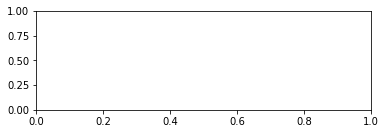

In [10]:
plt.subplot(2,1,1)
plt.plot(code_rates, train_accs)
plt.title("Accuracy after "+ str(num_epochs)+ " epochs vs code rate")
plt.ylabel("Training accuracy")
plt.grid(True)

plt.subplot(2,1,2)
plt.plot(code_rates, test_accs)
plt.ylabel("Testing accuracy")
plt.grid(True)
plt.xlabel("Code rate")
plt.show()